In [4]:
pip install scikit-learn

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

# Device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize all images to 64x64
    transforms.ToTensor()
])

# Load dataset
data_dir = r"C:/Users/anany/Downloads/Oily-Dry-Skin-Types/train"
train_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Get number of classes
num_classes = len(train_dataset.classes)

# CNN model
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, 16, 32, 32]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, 32, 16, 16]
        x = x.reshape(x.size(0), -1)            # flatten
        x = F.relu(self.fc1(x))
        return self.fc2(x)

# MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size=64*64*3, num_classes=3):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)   # flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

# Ensemble model
class EnsembleModel(nn.Module):
    def __init__(self, cnn_model, mlp_model):
        super(EnsembleModel, self).__init__()
        self.cnn_model = cnn_model
        self.mlp_model = mlp_model

    def forward(self, x_img):
        out1 = self.cnn_model(x_img)
        out2 = self.mlp_model(x_img)
        return (out1 + out2) / 2  # simple average

# Initialize models
cnn_model = CNNModel(num_classes=num_classes).to(device)
mlp_model = MLPModel(input_size=64*64*3, num_classes=num_classes).to(device)
ensemble_model = EnsembleModel(cnn_model, mlp_model).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    ensemble_model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = ensemble_model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Accuracy: {100 * correct / total:.2f}%")

# Save the ensemble model
torch.save(ensemble_model.state_dict(), "skin_ensemble_model.pth")
print("Model saved as 'skin_ensemble_model.pth'")

Epoch [1/10], Loss: 97.8155, Accuracy: 37.92%
Epoch [2/10], Loss: 92.8348, Accuracy: 41.44%
Epoch [3/10], Loss: 91.5880, Accuracy: 43.07%
Epoch [4/10], Loss: 88.2023, Accuracy: 47.79%
Epoch [5/10], Loss: 83.8297, Accuracy: 51.52%
Epoch [6/10], Loss: 75.5153, Accuracy: 59.25%
Epoch [7/10], Loss: 65.0818, Accuracy: 66.98%
Epoch [8/10], Loss: 54.0156, Accuracy: 74.17%
Epoch [9/10], Loss: 47.6258, Accuracy: 78.23%


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the dataset
df = pd.read_csv('cosmetics.csv')

# Display the first few rows
df.head()

,Label,Brand,Name,Price,Rank,Ingredients,Combination,Dry,Normal,Oily,Sensitive
0,Moisturizer,LA MER,Crème de la Mer,175,4.1,"Algae (Seaweed) Extract, Mineral Oil, Petrolat...",1,1,1,1,1
1,Moisturizer,SK-II,Facial Treatment Essence,179,4.1,"Galactomyces Ferment Filtrate (Pitera), Butyle...",1,1,1,1,1
2,Moisturizer,DRUNK ELEPHANT,Protini™ Polypeptide Cream,68,4.4,"Water, Dicaprylyl Carbonate, Glycerin, Ceteary...",1,1,1,1,0
3,Moisturizer,LA MER,The Moisturizing Soft Cream,175,3.8,"Algae (Seaweed) Extract, Cyclopentasiloxane, P...",1,1,1,1,1
4,Moisturizer,IT COSMETICS,Your Skin But Better™ CC+™ Cream with SPF 50+,38,4.1,"Water, Snail Secretion Filtrate, Phenyl Trimet...",1,1,1,1,1


In [27]:
# Check for missing values
df.isnull().sum()

Label          0
Brand          0
Name           0
Price          0
Rank           0
Ingredients    0
Combination    0
Dry            0
Normal         0
Oily           0
Sensitive      0
dtype: int64

In [28]:
# Get basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1472 entries, 0 to 1471
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Label        1472 non-null   object 
 1   Brand        1472 non-null   object 
 2   Name         1472 non-null   object 
 3   Price        1472 non-null   int64  
 4   Rank         1472 non-null   float64
 5   Ingredients  1472 non-null   object 
 6   Combination  1472 non-null   int64  
 7   Dry          1472 non-null   int64  
 8   Normal       1472 non-null   int64  
 9   Oily         1472 non-null   int64  
 10  Sensitive    1472 non-null   int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 126.6+ KB


✨ Welcome to GlowMatch ✨
How would you like to get skincare recommendations?
1. Enter skin type manually
2. Use camera to detect skin type


Choose option (1 or 2):  2


📸 Using camera to detect skin type...

Predicted Skin Type: Sensitive

Top product recommendations for: Sensitive skin 👇
Pore Refining Detox Double Cleanse by ERNO LASZLO - Price: $55 - Rank: 5.0 - Match Score: 1
Refreshing Gel Cleanser by CLARISONIC - Price: $19 - Rank: 5.0 - Match Score: 1
EGF Serum by BIOEFFECT - Price: $160 - Rank: 5.0 - Match Score: 1
Capture Totale Dreamskin Advanced Refill by DIOR - Price: $128 - Rank: 5.0 - Match Score: 1
30 Day Treatment by BIOEFFECT - Price: $290 - Rank: 5.0 - Match Score: 1


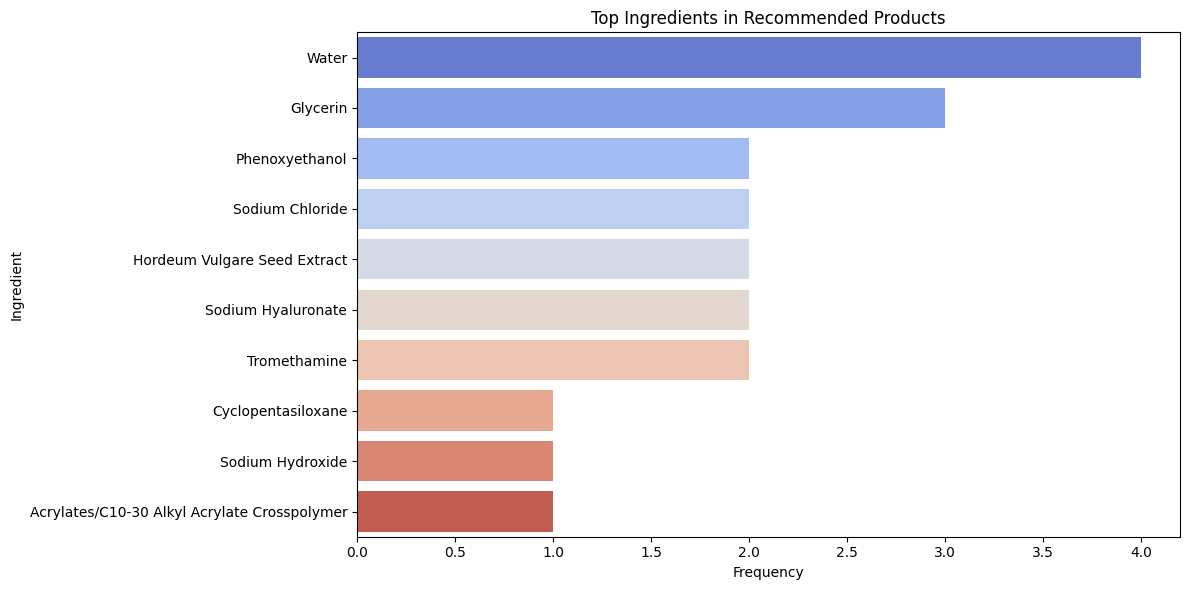

In [29]:
import cv2
import numpy as np
from keras.preprocessing import image
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from collections import Counter
import os
import torch


# Load pre-trained skin type model
cnn_model = CNNModel(num_classes=num_classes).to(device)
mlp_model = MLPModel(input_size=64*64*3, num_classes=num_classes).to(device)
ensemble_model = EnsembleModel(cnn_model, mlp_model).to(device)

# Load the saved model weights
ensemble_model.load_state_dict(torch.load('skin_ensemble_model.pth', map_location=torch.device('cpu')))
ensemble_model.eval()


def recommend_products(skin_types, top_n=5):
    recommendations = []
    for index, row in df.iterrows():
        match_score = 0
        match_found = False
        
        # Check if the product matches any of the user skin types
        for skin_type in skin_types:
            if row[skin_type] == 1:  # If the product suits this skin type
                match_score += 1
                match_found = True
        
        # If there is a match, add to recommendations
        if match_found:
            recommendations.append((row['Name'], row['Brand'], row['Price'], row['Rank'], match_score))
    
    # Sort products by match score, then by rank
    recommendations = sorted(recommendations, key=lambda x: (-x[4], -x[3]))  # Highest match score, then highest rank
    
    return recommendations[:top_n]

def get_ingredient_frequency(recommended_products, df):
    ingredients = []
    for name, brand, price, rank, match_score in recommended_products:
        product_row = df[df['Name'] == name].iloc[0]  # Find the row for this product
        ingredients_list = product_row['Ingredients'].split(', ')  # Split ingredients by comma
        ingredients.extend(ingredients_list)  # Add all ingredients to the list
    
    ingredient_counts = Counter(ingredients)
    ingredient_df = pd.DataFrame(ingredient_counts.items(), columns=['Ingredient', 'Frequency'])
    ingredient_df = ingredient_df.sort_values(by='Frequency', ascending=False).head(10)
    
    return ingredient_df

def plot_ingredient_frequency(ingredient_df):
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Frequency', y='Ingredient', data=ingredient_df, hue='Ingredient', palette='coolwarm', legend=False)
    plt.title('Top Ingredients in Recommended Products')
    plt.xlabel('Frequency')
    plt.ylabel('Ingredient')
    plt.tight_layout()
    plt.show()

def recommend_products_interactive():
    print("\nPlease enter your skin type(s) separated by commas.")
    print("Options: Dry, Oily, Sensitive, Combination, Normal")

    skin_input = input("Your skin type(s): ")
    skin_types = [s.strip().capitalize() for s in skin_input.split(',')]
    valid_types = ['Dry', 'Oily', 'Sensitive', 'Combination', 'Normal']
    skin_types = [s for s in skin_types if s in valid_types]

    if not skin_types:
        print("⚠️ No valid skin types entered.")
        return

    result = recommend_products(skin_types, top_n=5)
    print(f"\nTop product recommendations for: {', '.join(skin_types)} skin 👇")
    for r in result:
        print(f"{r[0]} by {r[1]} - Price: ${r[2]} - Rank: {r[3]} - Match Score: {r[4]}")

    ingredient_df = get_ingredient_frequency(result, df)
    plot_ingredient_frequency(ingredient_df)

def capture_image():
    # Use OpenCV to capture image from webcam
    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        cv2.imshow("Capture Skin Image", frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
    # Save the image for prediction
    img_path = 'captured_skin_image.jpg'
    cv2.imwrite(img_path, frame)
    return img_path

import torch
import numpy as np
from keras.preprocessing import image

import torch
import numpy as np
from keras.preprocessing import image

def predict_skin_type(img_path):
    # Load image and prepare it for model prediction
    img = image.load_img(img_path, target_size=(64, 64))  # Ensure size matches the input size for your model
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)

    # Convert to torch tensor and move to the correct device (CPU or GPU)
    img_array = torch.tensor(img_array, dtype=torch.float32).to(device)

    # Normalize image (if needed)
    img_array /= 255.0  # If your model expects normalized data, you can use this line

    # Transpose the image dimensions from [batch_size, height, width, channels] to [batch_size, channels, height, width]
    img_array = img_array.permute(0, 3, 1, 2)

    # Predict the skin type
    with torch.no_grad():  # Disable gradient calculation for inference
        model_output = ensemble_model(img_array)  # Forward pass through the ensemble model
        _, predicted_class = torch.max(model_output, 1)  # Get the index of the max value (class)

    skin_types = ['Dry', 'Oily', 'Sensitive', 'Combination', 'Normal']
    predicted_skin_type = skin_types[predicted_class.item()]  # Convert to Python scalar
    print(f"\nPredicted Skin Type: {predicted_skin_type}")
    return [predicted_skin_type]


def recommend_products_with_image():
    print("📸 Using camera to detect skin type...")
    
    # Capture skin image
    img_path = capture_image()
    
    # Predict skin type from the image
    skin_types = predict_skin_type(img_path)
    
    # Recommend products based on detected skin type
    print(f"\nTop product recommendations for: {', '.join(skin_types)} skin 👇")
    result = recommend_products(skin_types, top_n=5)
    for r in result:
        print(f"{r[0]} by {r[1]} - Price: ${r[2]} - Rank: {r[3]} - Match Score: {r[4]}")

    ingredient_df = get_ingredient_frequency(result, df)
    plot_ingredient_frequency(ingredient_df)

def main_menu():
    print("✨ Welcome to GlowMatch ✨")
    print("How would you like to get skincare recommendations?")
    print("1. Enter skin type manually")
    print("2. Use camera to detect skin type")

    choice = input("Choose option (1 or 2): ")

    if choice == '1':
        recommend_products_interactive()
    elif choice == '2':
        recommend_products_with_image()
    else:
        print("❌ Invalid choice. Please select 1 or 2.")

if __name__ == "__main__":
    main_menu()
